# 1. Build an image segmentation model using pytorch

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import torch
import cv2
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from torch.optim import Adam
from skimage import io, transform
import torchvision
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Dataset, random_split
from torchvision import transforms
# from torchvision.datasets import ImageFolder
import pandas as pd
import  torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from torchvision import transforms as T
from tqdm import tqdm
import os

from google.colab import drive
drive.mount('/content/drive')
np.random.seed(0)
torch.manual_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)

In [2]:
imgdir = "/content/drive/MyDrive/Datasets/Lung_segmentation/"

img = plt.imread(r"/content/drive/MyDrive/Datasets/Lung_segmentation/Train/Images/1.png")
mask = plt.imread(r"/content/drive/MyDrive/Datasets/Lung_segmentation/Train/Masks/1.png")
pred  = plt.imread("/content/drive/MyDrive/Datasets/Lung_segmentation/Train/Predict/1.png")

img.shape, mask.shape, pred.shape

((1024, 1024), (1024, 1024), (512, 512))

In [3]:
train_img_paths = sorted(os.listdir("/content/drive/MyDrive/Datasets/Lung_segmentation/Train/Images"))
train_mask_paths = sorted(os.listdir("/content/drive/MyDrive/Datasets/Lung_segmentation/Train/Masks"))

test_img_paths = sorted(os.listdir("/content/drive/MyDrive/Datasets/Lung_segmentation/Test/Images"))
test_mask_paths = sorted(os.listdir("/content/drive/MyDrive/Datasets/Lung_segmentation/Test/Masks"))

print("Checking if the images and masks are aligned")
print(train_img_paths == train_mask_paths)
print(test_img_paths == test_mask_paths)

Checking if the images and masks are aligned
True
True


In [4]:
class LungDataset(Dataset):
    def __init__(self, img_dir, img_paths, mask_paths, data = "Train", transforms=None):
        self.img_dir = img_dir 
        self.transforms = transforms
        self.data = data
        self.imgs = img_paths
        self.mask = mask_paths
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_dir, self.data, "Images", self.imgs[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.img_dir, self.data, "Masks", self.mask[idx]), cv2.IMREAD_UNCHANGED)

        if self.transforms:
            return self.transforms(img), self.transforms(mask)
        
        return img, mask
    
Img_size = 256  
def Otsu(img):
    mean = img.mean()
    img[img<= mean ] = 0
    img[img> mean] = 1
    return img
    
train_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((Img_size, Img_size)),
    T.ColorJitter(),
    T.RandomRotation(0.45),
    T.GaussianBlur(3),
    Otsu    
])

valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((Img_size, Img_size)),
        T.GaussianBlur(3),
])
    
trainds = LungDataset(imgdir, train_img_paths, train_mask_paths, transforms=train_transforms, data = "Train")
testds = LungDataset(imgdir, test_img_paths, test_mask_paths, transforms=valid_transforms, data = "Test")

batch_size = 6
pin_memory = True

traindl = DataLoader(trainds, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=2)
testdl = DataLoader(testds, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=2)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Image shape: torch.Size([6, 3, 256, 256]), Mask shape: torch.Size([6, 1, 256, 256])


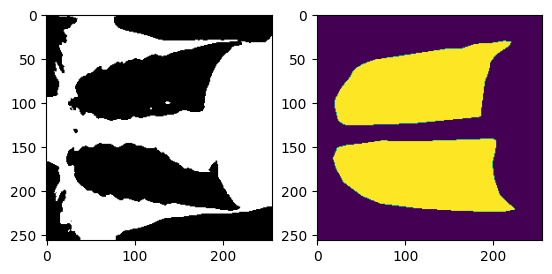

In [5]:
for img, mask  in traindl:
    print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")
    break

fig, axis = plt.subplots(1, 2)
axis[0].imshow(img[0].swapaxes(0, 2))
axis[1].imshow(mask[0].swapaxes(0, 2))

In [6]:
import torch
from torch import nn
from torchvision.models import  resnext50_32x4d, ResNeXt50_32X4D_Weights

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)
        return x


class ResNext50Unet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)


        # Up + sc
#         e4 = self.dropout(e4)
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
#         d1 = self.dropout(d1)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
#         out = self.dropout(out)
        out = torch.sigmoid(out)
        
        return out
resnextUnet = ResNext50Unet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


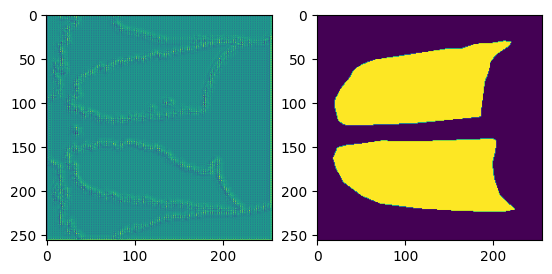

In [7]:
out = resnextUnet(img)

fig, axis = plt.subplots(1, 2)
axis[0].imshow(out[0].detach().numpy().swapaxes(0, 2))
axis[1].imshow(mask[0].swapaxes(0, 2))

In [8]:
class IoUScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoUScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU
iou = IoUScore()

In [9]:
lr = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
# loss_fn   = nn.BCEWithLogitsLoss()
iou = IoUScore()
model = ResNext50Unet().to(device)
opt =  optim.Adam(model.parameters(), lr=lr)

num_epochs = 40
trainSteps = int(len(trainds)/batch_size)
testSteps = int(len(testds)/batch_size)

train_loss = []
test_loss = []
test_iou = []
train_iou = []



for img, mask in testdl:
    img, mask = img.to(device), mask.to(device)
    res = model(img )
    print(res.shape)
    print("IOU score: ", iou(res, mask))
    break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([6, 1, 256, 256])
IOU score:  tensor(0.2549, device='cuda:0', grad_fn=<DivBackward0>)


In [10]:
prev_test_loss = 100
prev_train_loss = 100
patience = 2
trigger_times = 0

for epoch in range(1, num_epochs+1):
# Training loop
    model.train(True)
    correct = 0
    totalTrainLoss ,totalTestLoss, totalTrainIou, totalTestIou = 0, 0, 0, 0
    
    for X, y in tqdm(traindl):  
        X, y = X.to(device), y.to(device) 
        opt.zero_grad()
        yhat = model(X) 
        loss = (1- iou(y, yhat))
#         loss = loss_fn(y, yhat)
        iou_score = iou(y, yhat)
        totalTrainIou += iou_score.item()
        totalTrainLoss += loss.item()
        loss.backward()
        opt.step() 
    avg_iou = totalTrainIou / trainSteps
    avg_loss = (totalTrainLoss/trainSteps)
    train_iou.append(avg_iou)
    train_loss.append(avg_loss)
    
    model.train(False)

    # Valid loop
    with torch.no_grad():
        for X, y in tqdm(testdl): 
            X, y = X.to(device), y.to(device) 
            yhat = model(X) 
            loss = 1 - iou(y, yhat)
#             loss = loss_fn(y, yhat)
            iou_score = iou(y, yhat)
            totalTestIou += iou_score.item()
            totalTestLoss += loss.item()
        avg_iou = (totalTestIou/testSteps)
        avg_loss = (totalTestLoss/testSteps)
        if avg_iou > 0.8:
            torch.save(model, f"model_{round(avg_iou, 5)}.pth")
        test_loss.append(avg_loss)
        test_iou.append(avg_iou)
        print(f"Epoch:{epoch} train loss: {train_loss[-1]} \
     valid loss: {avg_loss} valid accuracy: {avg_iou} ")

#     # Early stopping
#     if avg_loss > prev_test_loss:
#         trigger_times += 1
#     if trigger_times > 0 and avg_loss < prev_test_loss:
#         trigger_times -= 1
#     if trigger_times == patience:
#         break
#     prev_test_loss = avg_loss
#     print("Trigger: ", trigger_times)
#     print("-"*50)
print("Training complete")

  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:1 train loss: 0.5740043386480862      valid loss: 0.4193340449622183 valid accuracy: 0.610968985340812 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:2 train loss: 0.25671099675329107      valid loss: 0.4068455100059509 valid accuracy: 0.6234575193939786 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:3 train loss: 0.21631126789222085      valid loss: 0.27957907951239386 valid accuracy: 0.7507239507906365 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:4 train loss: 0.19653908471415812      valid loss: 0.291038995439356 valid accuracy: 0.7392640348636743 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:5 train loss: 0.19350945187690563      valid loss: 0.2910063790552544 valid accuracy: 0.7392966512477759 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:6 train loss: 0.18080665428835646      valid loss: 0.20336131435452084 valid accuracy: 0.8269417159485094 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:7 train loss: 0.17835674653375955      valid loss: 0.22087048761772388 valid accuracy: 0.8094325426853064 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:8 train loss: 0.1725168416374608      valid loss: 0.2391464656049555 valid accuracy: 0.7911565646980748 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:9 train loss: 0.16769461255324514      valid loss: 0.3250232700145606 valid accuracy: 0.7052797602884697 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:10 train loss: 0.16550372328077043      valid loss: 0.30166227889783453 valid accuracy: 0.7286407514051958 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Epoch:11 train loss: 0.1626621959801007      valid loss: 0.22609303033713138 valid accuracy: 0.8042099999658989 


  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

KeyboardInterrupt: ignored

In [11]:
for img, mask in testdl:
    img, mask = img.to(device), mask.to(device)
    res = model(img )
    print(res.shape)
    print("IOU: ", iou(res, mask))
    break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([6, 1, 256, 256])
IOU:  tensor(0.8599, device='cuda:0', grad_fn=<DivBackward0>)


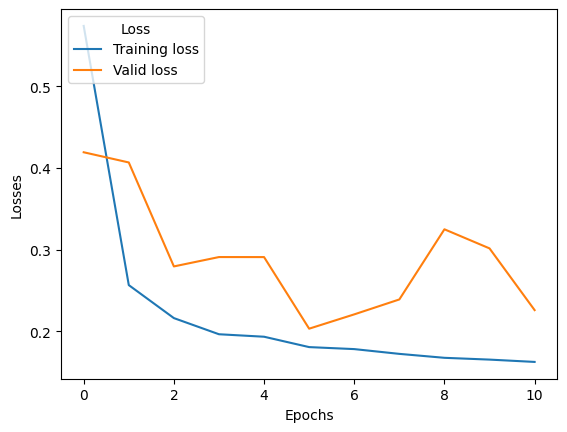

In [12]:
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss, label='Valid loss')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(loc='upper left', title='Loss');

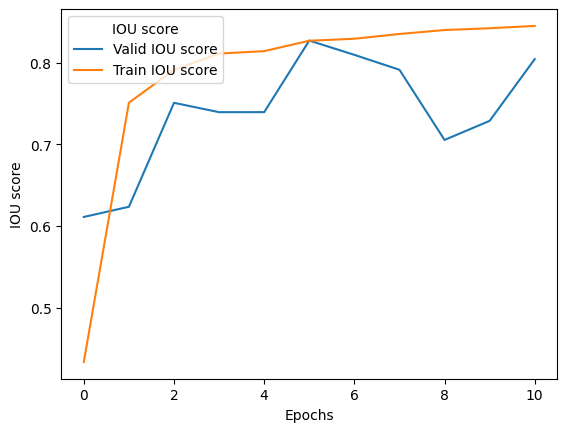

In [15]:
plt.plot(test_iou,label='Valid IOU score')
plt.plot(train_iou, label='Train IOU score')
plt.xlabel("Epochs")
plt.ylabel("IOU score")
plt.legend(loc='upper left', title='IOU score');

# Get the best model

In [16]:
ious = []
modelf = []
for f in os.listdir():
    if f.endswith(".pth"):
        modelf.append(f)
        _, iou_score = f.split("_")
        ious.append(float(iou_score[:-4]))

with torch.no_grad():
    best_model = torch.load(modelf[np.argmax(ious)])
    best_model.eval()


# 3.Evaluate your model using the test images

In [19]:
for img, mask in testdl:
    img, mask = img.to(device), mask.to(device)
    res = best_model(img )
    print(res.shape)
    print("IOU: ", iou(res, mask))
    break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([6, 1, 256, 256])
IOU:  tensor(0.8116, device='cuda:0', grad_fn=<DivBackward0>)


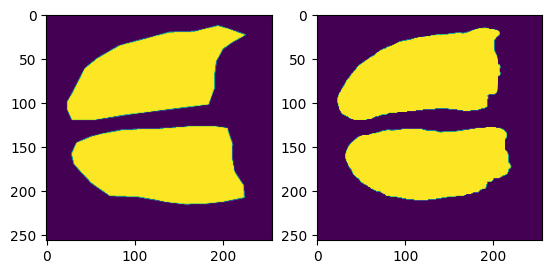

In [20]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(mask[0].cpu().swapaxes(0, 2))
axes[1].imshow(res[0].cpu().detach().numpy().swapaxes(0, 2))

# 4. Your IoU score should be higher than 0.8

In [21]:
print("Test IOU: ", iou(res, mask))


Test IOU:  tensor(0.8116, device='cuda:0', grad_fn=<DivBackward0>)


# 5. Write a 2-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points